#DAGMM model(Deep autoencoding gaussian mixture model)
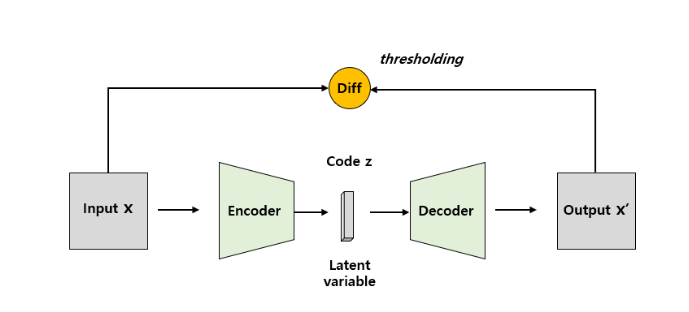
차원 축소와 밀도 함수 추정을 동시에 최적화하기 위해 각 개체에 대해 **compression network**(데이터 차원축소 시에 오토인코더 사용)를 적용하여 저차원 입력을 계산한 뒤, 혼합 밀도 함수를 추정(density estimation에서 데이터가 생성되었을 가능도가 높은 분포 예측)하는 **estimation network**를 사용하여 GMM의 모수를 직접 추정할 수 있습니다

-모델의 장점,특징(해당 모델을 선정한 이유)
1.샘플과 특성이 많은 대용량 데이터셋을 다룰 수 있음.
2.compression network와 estimation network로 이루어져 있음.
3.비정상 sample이 정상 sample에 비해 loss(mse)가 커지게 되므로 복원 loss가 일정 threshold를 넘으면 비정상,아니면 정상으로 판단
4.인코더와 디코더를 통해 압축했다가 압축해제하여 입력과 출력층의 뉴런이 동일한 Bottleneck형
5.-입력 데이터의 가장 중요한 특징만을 학습하므로,NOISE가 아닌 주요 특징에 대해서만 학습
-모델의 한계
1.모델설정에 있어 에러가 잘 난다.

-의문점
1.원래는 bottleneck모형을 기반으로 하는데
점점 z-dim을 늘릴 때 더 성능이 좋았음.

-성능 개선점
1.learning rate을 0.1대로 설정할 때 성능 잘나옴.

참고URL:
https://blog.naver.com/wjsduwls703/222112563912

DAGMM
https://www.notion.so/260defd76ab042c29f816e28b719d15b#734130a03e5647f58861bd4c23093821
https://tam5917.hatenablog.com/entry/2021/08/20/200017
https://dacon.io/codeshare/4551?dtype=recent
https://www.slideshare.net/ChoDae/ss-90334482
https://dacon.io/competitions/official/235930/codeshare/5508?page=1&dtype=recent
https://www.kaggle.com/code/shivamb/semi-supervised-classification-using-autoencoders/notebook
https://www.kaggle.com/robinteuwens/anomaly-detection-with-auto-encoders

이상치 탐지 모델
https://velog.io/@jaylnne/ML-%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C-%EC%82%AC%EA%B8%B0-%EA%B1%B0%EB%9E%98-%ED%83%90%EC%A7%80-%EB%AA%A8%EB%8D%B8-%EB%A7%8C%EB%93%A4%EC%96%B4%EB%B3%B4%EA%B8%B0-3
https://velog.io/@bgly/%EB%8D%B0%EC%9D%B4%EC%BD%98%EA%B2%BD%EC%97%B0%EB%8C%80%ED%9A%8C%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C-%EC%82%AC%EA%B8%B0-%ED%83%90%EC%A7%80-%ED%83%90%EC%83%89

##필요한 라이브러리 불러오기

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Dacon

/content/drive/MyDrive/Dacon


In [ ]:
##!git clone https://github.com/tnakae/DAGMM.git #github에서 해당 모델을 다운로드한다.

In [ ]:
%cd /content/drive/MyDrive/Dacon/DAGMM

/content/drive/MyDrive/Dacon/DAGMM


In [ ]:
!python setup.py install

running install
running build
running build_py
running install_lib
creating /usr/local/lib/python3.7/dist-packages/dagmm
copying build/lib/dagmm/gmm.py -> /usr/local/lib/python3.7/dist-packages/dagmm
copying build/lib/dagmm/estimation_net.py -> /usr/local/lib/python3.7/dist-packages/dagmm
copying build/lib/dagmm/compression_net.py -> /usr/local/lib/python3.7/dist-packages/dagmm
copying build/lib/dagmm/__init__.py -> /usr/local/lib/python3.7/dist-packages/dagmm
copying build/lib/dagmm/dagmm.py -> /usr/local/lib/python3.7/dist-packages/dagmm
byte-compiling /usr/local/lib/python3.7/dist-packages/dagmm/gmm.py to gmm.cpython-37.pyc
byte-compiling /usr/local/lib/python3.7/dist-packages/dagmm/estimation_net.py to estimation_net.cpython-37.pyc
byte-compiling /usr/local/lib/python3.7/dist-packages/dagmm/compression_net.py to compression_net.cpython-37.pyc
byte-compiling /usr/local/lib/python3.7/dist-packages/dagmm/__init__.py to __init__.cpython-37.pyc
byte-compiling /usr/local/lib/python3.7/di

In [ ]:
pip install tensorflow==1.15.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110.5 MB 36 kB/s 
     |████████████████████████████████| 50 kB 5.6 MB/s 
     |████████████████████████████████| 503 kB 57.0 MB/s 
     |████████████████████████████████| 3.8 MB 33.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=7908e08cfcfec58b7d6e4d24a71cfe4dd7eb1b7811c1fdf7f42b0bb660515c9b
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import tensorflow as tf
##import DAGMM.dgmm
from dagmm import DAGMM #불러온 모델 import
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')




In [ ]:
##device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

##파일 불러오기

In [ ]:
!unzip '/content/drive/MyDrive/Dacon/open.zip'

Archive:  /content/drive/MyDrive/Dacon/open.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ㅛ
error:  invalid response [ㅛ]
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ㅛ
error:  invalid response [ㅛ]
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ㅛ
error:  invalid response [ㅛ]
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ㅛ
error:  invalid response [ㅛ]
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                y
y
y
y
y

replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: train.csv               
replace val.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: val.csv                 


In [ ]:
train_df = pd.read_csv('./train.csv')
val_df = pd.read_csv('./val.csv') 

이상치 비율 확인

In [ ]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal
print(f'Validation contamination : [{val_contamination}]')

Validation contamination : [0.0010551491277433877]


In [ ]:
train_df2 = train_df.drop(columns=['ID'])
val_df2 = val_df.drop(columns=['ID'])

In [ ]:
X=pd.get_dummies(train_df.iloc[:,:-1]).values

In [ ]:
##하이퍼파라미터 준비?

파라미터 후보1)

comp_activation="tanh",
                    estim_activation="tanh",
                    lambda_energy=0.01,
                    lambda_cov=0.005,
                    batch_size=128,
                    dropout_rate=0.25,
                    contamination=contamination,
                    verbose=0

파라미터 후보2)
  comp_hiddens=[32,16,2], comp_activation=tf.nn.tanh,
  est_hiddens=[16.8], est_activation=tf.nn.tanh,
  est_dropout_ratio=0.25
**2**
  epochs=1000,
                    comp_neurons=[16, 8, 1],
                    estim_neurons=[8, 4],
                    comp_activation="tanh",
                    estim_activation="tanh",
                    lambda_energy=0.01,
                    lambda_cov=0.005,
                    batch_size=128,
                    dropout_rate=0.25,
                    contamination=contamination,
                    verbose=0

##다른 거 굳이 하지말고 파라미터 제대로 공부해서 바꿔보기


In [ ]:
model = DAGMM(
    comp_hiddens=[256, 128, 16, 2], comp_activation=tf.nn.tanh,
    ##compression-Autoencoder
    est_hiddens=[16, 8], est_dropout_ratio=0.5, est_activation=tf.nn.tanh,
    #estimation-GNN comp_hiddens[2]가 est_hiddens[0]
    learning_rate=0.01, epoch_size=1000, minibatch_size=16384,random_seed=1111
)
##batch원래 1024
#0.001에서lr 0.01로 바꿨더니 나음.
#0.02 구림
#필터바꿔서 [256,128,32,2],[32,4]에 0.01
#동일하게 lr 0.001?
# [256,128,16,4][16,8] 0.01 에폭 1000에 6.529
#마지막에 256...2하면 더 구림
#안되면 [150,90,30]


In [ ]:
model.fit(train_df)

 epoch 100/1000 : loss = 20.945
 epoch 200/1000 : loss = 15.287
 epoch 300/1000 : loss = 13.887
 epoch 400/1000 : loss = 12.961
 epoch 500/1000 : loss = 12.474
 epoch 600/1000 : loss = 11.964
 epoch 700/1000 : loss = 11.688
 epoch 800/1000 : loss = 12.747
 epoch 900/1000 : loss = 12.013
 epoch 1000/1000 : loss = 12.140


##모델 구현




Training DAGMM Model

In [ ]:
val_x = val_df.drop(columns=['ID', 'Class']) # Input Data
val_y = val_df['Class'] # Label

test_df = pd.read_csv('./test.csv')
test_x = test_df.drop(columns=['ID'])
y_pred = model.predict(val_x)

ValueError: ignored

In [ ]:
anomaly_energy_threshold = np.percentile(y_pred, 80)
print(f"Energy thleshold to detect anomaly : {anomaly_energy_threshold:.3f}")

NameError: ignored

In [ ]:
# Detect anomalies from test data
y_pred_flag = np.where(y_pred >= anomaly_energy_threshold, 1, 0)

NameError: ignored

In [ ]:
prec, recall, fscore, _ = precision_recall_fscore_support(val_y, y_pred_flag, average="binary")
print(f" Precision = {prec:.3f}")
print(f" Recall    = {recall:.3f}")
print(f" F1-Score  = {fscore:.3f}")